In [1]:
import processing as pr

In [2]:
import math
import numpy as np

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm
import math

In [4]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]

In [5]:
class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                   kernel_size=3, padding=padding, padding_mode='circular', bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x

In [6]:
class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, dropout=0.0):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = self.value_embedding(x) + self.position_embedding(x)
        return self.dropout(x)

In [7]:
class TriangularCausalMask():
    def __init__(self, B, L, device="cpu"):
        mask_shape = [B, 1, L, L]
        with torch.no_grad():
            self._mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)

    @property
    def mask(self):
        return self._mask

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
from math import sqrt
import os

In [9]:
class AnomalyAttention(nn.Module):
    def __init__(self, win_size, mask_flag=True, scale=None, attention_dropout=0.0, output_attention=False):
        super(AnomalyAttention, self).__init__()
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)
        window_size = win_size
        self.distances = torch.zeros((window_size, window_size))
        for i in range(window_size):
            for j in range(window_size):
                self.distances[i][j] = abs(i - j)

    def forward(self, queries, keys, values, sigma, attn_mask):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = self.scale or 1. / sqrt(E)

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)
        if self.mask_flag:
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, L, device=queries.device)
            scores.masked_fill_(attn_mask.mask, -np.inf)
        attn = scale * scores

        sigma = sigma.transpose(1, 2)  # B L H ->  B H L
        window_size = attn.shape[-1]
        sigma = torch.sigmoid(sigma * 5) + 1e-5
        sigma = torch.pow(3, sigma) - 1
        sigma = sigma.unsqueeze(-1).repeat(1, 1, 1, window_size)  # B H L L
        prior = self.distances.unsqueeze(0).unsqueeze(0).repeat(sigma.shape[0], sigma.shape[1], 1, 1)
        prior = 1.0 / (math.sqrt(2 * math.pi) * sigma) * torch.exp(-prior ** 2 / 2 / (sigma ** 2))

        series = self.dropout(torch.softmax(attn, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", series, values)

        if self.output_attention:
            return (V.contiguous(), series, prior, sigma)
        else:
            return (V.contiguous(), None)

In [10]:
class AttentionLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads, d_keys=None,
                 d_values=None):
        super(AttentionLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)
        self.norm = nn.LayerNorm(d_model)
        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model,
                                          d_keys * n_heads)
        self.key_projection = nn.Linear(d_model,
                                        d_keys * n_heads)
        self.value_projection = nn.Linear(d_model,
                                          d_values * n_heads)
        self.sigma_projection = nn.Linear(d_model,
                                          n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)

        self.n_heads = n_heads

    def forward(self, queries, keys, values, attn_mask):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads
        x = queries
        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)
        sigma = self.sigma_projection(x).view(B, L, H)

        out, series, prior, sigma = self.inner_attention(
            queries,
            keys,
            values,
            sigma,
            attn_mask
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), series, prior, sigma

In [11]:
class EncoderLayer(nn.Module):
    def __init__(self, attention, d_model, d_ff=None, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, attn_mask=None):
        new_x, attn, mask, sigma = self.attention(
            x, x, x,
            attn_mask=attn_mask
        )
        x = x + self.dropout(new_x)
        y = x = self.norm1(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))

        return self.norm2(x + y), attn, mask, sigma

In [12]:
class Encoder(nn.Module):
    def __init__(self, attn_layers, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.norm = norm_layer

    def forward(self, x, attn_mask=None):
        # x [B, L, D]
        series_list = []
        prior_list = []
        sigma_list = []
        for attn_layer in self.attn_layers:
            x, series, prior, sigma = attn_layer(x, attn_mask=attn_mask)
            series_list.append(series)
            prior_list.append(prior)
            sigma_list.append(sigma)

        if self.norm is not None:
            x = self.norm(x)

        return x, series_list, prior_list, sigma_list

In [13]:
class AnomalyTransformer(nn.Module):
    def __init__(self, win_size, enc_in, c_out, d_model=512, n_heads=8, e_layers=3, d_ff=512,
                 dropout=0.0, activation='gelu', output_attention=True):
        super(AnomalyTransformer, self).__init__()
        self.output_attention = output_attention

        # Encoding
        self.embedding = DataEmbedding(enc_in, d_model, dropout)

        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        AnomalyAttention(win_size, False, attention_dropout=dropout, output_attention=output_attention),
                        d_model, n_heads),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation=activation
                ) for l in range(e_layers)
            ],
            norm_layer=torch.nn.LayerNorm(d_model)
        )

        self.projection = nn.Linear(d_model, c_out, bias=True)

    def forward(self, x):
        enc_out = self.embedding(x)
        enc_out, series, prior, sigmas = self.encoder(enc_out)
        enc_out = self.projection(enc_out)

        if self.output_attention:
            return enc_out, series, prior, sigmas
        else:
            return enc_out  # [B, L, D]

In [14]:
def my_kl_loss(p, q):
    res = p * (torch.log(p + 0.0001) - torch.log(q + 0.0001))
    return torch.mean(torch.sum(res, dim=-1), dim=1)

In [15]:
import time

In [16]:
model_save_path = "C:/Users/minseok/Desktop/project/Anomaly-detection/anomaly_detection/train/torch_save"

In [17]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, dataset_name='', delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.best_score2 = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.val_loss2_min = np.Inf
        self.delta = delta
        self.dataset = dataset_name

    def __call__(self, val_loss, val_loss2, model, path):
        score = -val_loss
        score2 = -val_loss2
        if self.best_score is None:
            self.best_score = score
            self.best_score2 = score2
            self.save_checkpoint(val_loss, val_loss2, model, path)
        elif score < self.best_score + self.delta or score2 < self.best_score2 + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_score2 = score2
            self.save_checkpoint(val_loss, val_loss2, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, val_loss2, model, path):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), os.path.join(path, str(self.dataset) + '_checkpoint.pth'))
        self.val_loss_min = val_loss
        self.val_loss2_min = val_loss2

In [18]:
dataset = 'SMD'

In [19]:
data_path = "C:/Users/minseok/Desktop/project/Anomaly-detection/anomaly_detection/train/data_set/SMD"

In [20]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader

In [21]:
class SMDSegLoader(object):
    def __init__(self, data_path, win_size, step, mode="train"):
        self.mode = mode
        self.step = step
        self.win_size = win_size
        self.scaler = StandardScaler()
        data = np.load(data_path + "/SMD_train.npy")
        self.scaler.fit(data)
        data = self.scaler.transform(data)
        test_data = np.load(data_path + "/SMD_test.npy")
        self.test = self.scaler.transform(test_data)
        self.train = data
        data_len = len(self.train)
        self.val = self.train[(int)(data_len * 0.8):]
        self.test_labels = np.load(data_path + "/SMD_test_label.npy")

    def __len__(self):

        if self.mode == "train":
            return (self.train.shape[0] - self.win_size) // self.step + 1
        elif (self.mode == 'val'):
            return (self.val.shape[0] - self.win_size) // self.step + 1
        elif (self.mode == 'test'):
            return (self.test.shape[0] - self.win_size) // self.step + 1
        else:
            return (self.test.shape[0] - self.win_size) // self.win_size + 1

    def __getitem__(self, index):
        index = index * self.step
        if self.mode == "train":
            return np.float32(self.train[index:index + self.win_size]), np.float32(self.test_labels[0:self.win_size])
        elif (self.mode == 'val'):
            return np.float32(self.val[index:index + self.win_size]), np.float32(self.test_labels[0:self.win_size])
        elif (self.mode == 'test'):
            return np.float32(self.test[index:index + self.win_size]), np.float32(
                self.test_labels[index:index + self.win_size])
        else:
            return np.float32(self.test[
                              index // self.step * self.win_size:index // self.step * self.win_size + self.win_size]), np.float32(
                self.test_labels[index // self.step * self.win_size:index // self.step * self.win_size + self.win_size])

In [22]:
def get_loader_segment(data_path, batch_size, win_size=100, step=100, mode='train', dataset='SMD'):
    if (dataset == 'SMD'):
        dataset = SMDSegLoader(data_path, win_size, step, mode)
        
    shuffle = False
    if mode == 'train':
        shuffle = True

    data_loader = DataLoader(dataset=dataset,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             num_workers=0)
    return data_loader

In [23]:
batch_size = 128
win_size = 100

In [24]:
train_loader = get_loader_segment(data_path, batch_size=batch_size, win_size=win_size, mode='train', dataset=dataset)

In [25]:
num_epochs = 10

In [26]:
model = AnomalyTransformer(win_size=win_size, enc_in=38, c_out=38, e_layers=3)

In [27]:
lr = 1e-4
k = 3

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [29]:
def adjust_learning_rate(optimizer, epoch, lr_):
    lr_adjust = {epoch: lr_ * (0.5 ** ((epoch - 1) // 1))}
    if epoch in lr_adjust.keys():
        lr = lr_adjust[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print('Updating learning rate to {}'.format(lr))

In [30]:
def vali(vali_loader):
    model.eval()

    loss_1 = []
    loss_2 = []
    for i, (input_data, _) in enumerate(vali_loader):
        input = input_data.float()
        output, series, prior, _ = model(input)
        series_loss = 0.0
        prior_loss = 0.0
        for u in range(len(prior)):
            series_loss += (torch.mean(my_kl_loss(series[u], (
                    prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                            win_size)).detach())) + torch.mean(
                my_kl_loss(
                    (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                            win_size)).detach(),
                    series[u])))
            prior_loss += (torch.mean(
                my_kl_loss((prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                                    win_size)),
                            series[u].detach())) + torch.mean(
                my_kl_loss(series[u].detach(),
                            (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                                    win_size)))))
        series_loss = series_loss / len(prior)
        prior_loss = prior_loss / len(prior)

        rec_loss = criterion(output, input)
        loss_1.append((rec_loss - k * series_loss).item())
        loss_2.append((rec_loss + k * prior_loss).item())

    return np.average(loss_1), np.average(loss_2)

In [31]:
vali_loader = get_loader_segment(data_path, batch_size=batch_size, win_size=win_size,mode='val',dataset=dataset)

In [32]:
test_loader = get_loader_segment(data_path, batch_size=batch_size, win_size=win_size,mode='test',dataset=dataset)

In [33]:
print("======================TRAIN MODE======================")

time_now = time.time()
path = model_save_path
if not os.path.exists(path):
    os.makedirs(path)
early_stopping = EarlyStopping(patience=3, verbose=True, dataset_name=dataset)
train_steps = len(train_loader)

for epoch in range(num_epochs):
    iter_count = 0
    loss1_list = []
    print(data_path)
    epoch_time = time.time()
    model.train()
    for i, (input_data,labels) in enumerate(train_loader):

        optimizer.zero_grad()
        iter_count += 1
        input = input_data.float()

        output, series, prior, _ = model(input)

        # calculate Association discrepancy
        series_loss = 0.0
        prior_loss = 0.0
        for u in range(len(prior)):
            series_loss += (torch.mean(my_kl_loss(series[u], (
                    prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                            win_size)).detach())) + torch.mean(
                my_kl_loss((prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                                    win_size)).detach(),
                            series[u])))
            prior_loss += (torch.mean(my_kl_loss(
                (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                        win_size)),
                series[u].detach())) + torch.mean(
                my_kl_loss(series[u].detach(), (
                        prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                                win_size)))))
        series_loss = series_loss / len(prior)
        prior_loss = prior_loss / len(prior)

        rec_loss = criterion(output, input)

        loss1_list.append((rec_loss - k * series_loss).item())
        loss1 = rec_loss - k * series_loss
        loss2 = rec_loss + k * prior_loss

        if (i + 1) % 100 == 0:
            speed = (time.time() - time_now) / iter_count
            left_time = speed * ((num_epochs - epoch) * train_steps - i)
            print('\tspeed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
            iter_count = 0
            time_now = time.time()

        # Minimax strategy
        loss1.backward(retain_graph=True)
        optimizer.step()
        loss2.backward()
        optimizer.step()

    print("Epoch: {} cost time: {}".format(epoch + 1, time.time() - epoch_time))
    train_loss = np.average(loss1_list)

    vali_loss1, vali_loss2 = vali(test_loader)

    print(
        "Epoch: {0}, Steps: {1} | Train Loss: {2:.7f} Vali Loss: {3:.7f} ".format(
            epoch + 1, train_steps, train_loss, vali_loss1))
    early_stopping(vali_loss1, vali_loss2, model, path)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    adjust_learning_rate(optimizer, epoch + 1, lr)

======================TRAIN MODE======================
C:/Users/minseok/Desktop/project/Anomaly-detection/anomaly_detection/train/data_set/SMD
Epoch: 1 cost time: 398.4130051136017
Epoch: 1, Steps: 56 | Train Loss: -35.5483444 Vali Loss: -44.1161989 
Validation loss decreased (inf --> -44.116199).  Saving model ...
Updating learning rate to 0.0001
C:/Users/minseok/Desktop/project/Anomaly-detection/anomaly_detection/train/data_set/SMD
Epoch: 2 cost time: 461.5648989677429
Epoch: 2, Steps: 56 | Train Loss: -46.0153963 Vali Loss: -45.9507163 
EarlyStopping counter: 1 out of 3
Updating learning rate to 5e-05
C:/Users/minseok/Desktop/project/Anomaly-detection/anomaly_detection/train/data_set/SMD
Epoch: 3 cost time: 479.79224729537964
Epoch: 3, Steps: 56 | Train Loss: -47.2062595 Vali Loss: -46.5080820 
EarlyStopping counter: 2 out of 3
Updating learning rate to 2.5e-05
C:/Users/minseok/Desktop/project/Anomaly-detection/anomaly_detection/train/data_set/SMD
Epoch: 4 cost time: 515.03964376449

In [34]:
thre_loader = get_loader_segment(data_path, batch_size=batch_size, win_size=win_size,
                                              mode='thre',
                                              dataset=dataset)

In [36]:
anormly_ratio = 0.5

In [37]:
model.load_state_dict(torch.load(os.path.join(str(model_save_path), str(dataset) + '_checkpoint.pth')))
model.eval()
temperature = 50

print("======================TEST MODE======================")

criterion = nn.MSELoss(reduce=False)

# (1) stastic on the train set
attens_energy = []
for i, (input_data, labels) in enumerate(train_loader):
    input = input_data.float()
    output, series, prior, _ = model(input)
    loss = torch.mean(criterion(input, output), dim=-1)
    series_loss = 0.0
    prior_loss = 0.0
    for u in range(len(prior)):
        if u == 0:
            series_loss = my_kl_loss(series[u], (
                    prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                            win_size)).detach()) * temperature
            prior_loss = my_kl_loss(
                (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                        win_size)),
                series[u].detach()) * temperature
        else:
            series_loss += my_kl_loss(series[u], (
                    prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                            win_size)).detach()) * temperature
            prior_loss += my_kl_loss(
                (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                        win_size)),
                series[u].detach()) * temperature

    metric = torch.softmax((-series_loss - prior_loss), dim=-1)
    cri = metric * loss
    cri = cri.detach().cpu().numpy()
    attens_energy.append(cri)

attens_energy = np.concatenate(attens_energy, axis=0).reshape(-1)
train_energy = np.array(attens_energy)

# (2) find the threshold
attens_energy = []
for i, (input_data, labels) in enumerate(thre_loader):
    input = input_data.float()
    output, series, prior, _ = model(input)

    loss = torch.mean(criterion(input, output), dim=-1)

    series_loss = 0.0
    prior_loss = 0.0
    for u in range(len(prior)):
        if u == 0:
            series_loss = my_kl_loss(series[u], (
                    prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                            win_size)).detach()) * temperature
            prior_loss = my_kl_loss(
                (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                        win_size)),
                series[u].detach()) * temperature
        else:
            series_loss += my_kl_loss(series[u], (
                    prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                            win_size)).detach()) * temperature
            prior_loss += my_kl_loss(
                (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                        win_size)),
                series[u].detach()) * temperature
    # Metric
    metric = torch.softmax((-series_loss - prior_loss), dim=-1)
    cri = metric * loss
    cri = cri.detach().cpu().numpy()
    attens_energy.append(cri)

attens_energy = np.concatenate(attens_energy, axis=0).reshape(-1)
test_energy = np.array(attens_energy)
combined_energy = np.concatenate([train_energy, test_energy], axis=0)
thresh = np.percentile(combined_energy, 100 - anormly_ratio)
print("Threshold :", thresh)

# (3) evaluation on the test set
test_labels = []
attens_energy = []
for i, (input_data, labels) in enumerate(thre_loader):
    input = input_data.float()
    output, series, prior, _ = model(input)

    loss = torch.mean(criterion(input, output), dim=-1)

    series_loss = 0.0
    prior_loss = 0.0
    for u in range(len(prior)):
        if u == 0:
            series_loss = my_kl_loss(series[u], (
                    prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                            win_size)).detach()) * temperature
            prior_loss = my_kl_loss(
                (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                        win_size)),
                series[u].detach()) * temperature
        else:
            series_loss += my_kl_loss(series[u], (
                    prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                            win_size)).detach()) * temperature
            prior_loss += my_kl_loss(
                (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                        win_size)),
                series[u].detach()) * temperature
    metric = torch.softmax((-series_loss - prior_loss), dim=-1)

    cri = metric * loss
    cri = cri.detach().cpu().numpy()
    attens_energy.append(cri)
    test_labels.append(labels)

attens_energy = np.concatenate(attens_energy, axis=0).reshape(-1)
test_labels = np.concatenate(test_labels, axis=0).reshape(-1)
test_energy = np.array(attens_energy)
test_labels = np.array(test_labels)

pred = (test_energy > thresh).astype(int)

gt = test_labels.astype(int)

print("pred:   ", pred.shape)
print("gt:     ", gt.shape)

# detection adjustment
anomaly_state = False
for i in range(len(gt)):
    if gt[i] == 1 and pred[i] == 1 and not anomaly_state:
        anomaly_state = True
        for j in range(i, 0, -1):
            if gt[j] == 0:
                break
            else:
                if pred[j] == 0:
                    pred[j] = 1
        for j in range(i, len(gt)):
            if gt[j] == 0:
                break
            else:
                if pred[j] == 0:
                    pred[j] = 1
    elif gt[i] == 0:
        anomaly_state = False
    if anomaly_state:
        pred[i] = 1

pred = np.array(pred)
gt = np.array(gt)
print("pred: ", pred.shape)
print("gt:   ", gt.shape)

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(gt, pred)
precision, recall, f_score, support = precision_recall_fscore_support(gt, pred,
                                                                        average='binary')
print(
    "Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f} ".format(
        accuracy, precision,
        recall, f_score))

======================TEST MODE======================


c:\Users\minseok\anaconda3\envs\py36\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Threshold : 0.1439638721197787
pred:    (708400,)
gt:      (708400,)
pred:  (708400,)
gt:    (708400,)
Accuracy : 0.9931, Precision : 0.8923, Recall : 0.9474, F-score : 0.9190 


In [54]:
pred = np.random.randint(2, size=708400)

In [55]:
anomaly_state = False
for i in range(len(gt)):
    if gt[i] == 1 and pred[i] == 1 and not anomaly_state:
        anomaly_state = True
        for j in range(i, 0, -1):
            if gt[j] == 0:
                break
            else:
                if pred[j] == 0:
                    pred[j] = 1
        for j in range(i, len(gt)):
            if gt[j] == 0:
                break
            else:
                if pred[j] == 0:
                    pred[j] = 1
    elif gt[i] == 0:
        anomaly_state = False
    if anomaly_state:
        pred[i] = 1

pred = np.array(pred)
gt = np.array(gt)
print("pred: ", pred.shape)
print("gt:   ", gt.shape)

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(gt, pred)
precision, recall, f_score, support = precision_recall_fscore_support(gt, pred,
                                                                        average='binary')
print(
    "Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f} ".format(
        accuracy, precision,
        recall, f_score))

pred:  (708400,)
gt:    (708400,)
Accuracy : 0.5207, Precision : 0.0797, Recall : 0.9984, F-score : 0.1476 


In [41]:
test_energy.shape

(708400,)

In [43]:
gt.shape

(708400,)

In [44]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

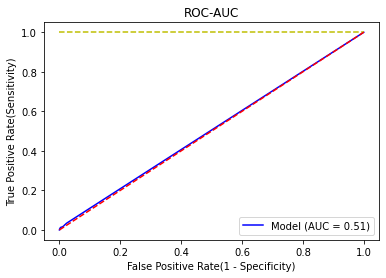

In [45]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(gt, test_energy)
roc_auc = metrics.roc_auc_score(gt, test_energy)
plt.title('ROC-AUC')
plt.xlabel('False Positive Rate(1 - Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')

plt.plot(false_positive_rate, true_positive_rate, 'b', label='Model (AUC = %0.2f)'% roc_auc)
plt.plot([0,1],[1,1],'y--')
plt.plot([0,1],[0,1],'r--')

plt.legend(loc='lower right')
plt.show()

In [46]:
pred = (test_energy > thresh).astype(int)

In [47]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(gt, pred)
precision, recall, f_score, support = precision_recall_fscore_support(gt, pred,
                                                                        average='binary')
print(
    "Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f} ".format(
        accuracy, precision,
        recall, f_score))

Accuracy : 0.9542, Precision : 0.1031, Recall : 0.0131, F-score : 0.0233 


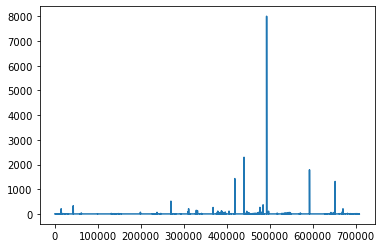

In [48]:
plt.plot(test_energy)

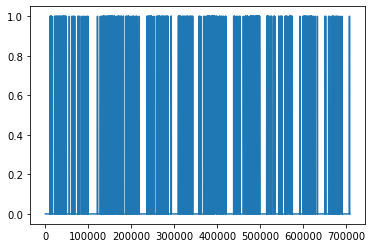

In [49]:
plt.plot(test_labels)

In [53]:
pred.shape

(708400,)